## Introduction

The project will be according to the universal workflow of machine learning.
The workflow begins with defining the problem, and for this project it will be trying to solve for binary classification on if the tweets are positive are negative regarding US Airline.

The project uses dataset from [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) retrieved from kaggle. The input of the model will be the text post, and output will be the type/ airline_sentiment, if it is negative or positive type of post about the airline

Things to note would be that because in this dataset, data are split into negative, neutral and positive, I intend to only focus on the positive and negative, thus will be removing data that are neutral.

The measure of success for this problem will be accuracy, because how accurate the model will be able to determine if the post on twitter is positive or negative would be imporant. 

### Preparing the Data

The dataset contains rows of data where there are 14600 rows of data,the output of the data will be predicted based on the input that is the text posted from users.

In [1]:
!pip install tensorflow

In [2]:
!pip install keras

### Import necessary modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import collections
import tensorflow as tf
import nltk

from pathlib import Path
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras import models, layers, regularizers

### Download nltk resource

Download stopwards package to use

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samantha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Read the csv file

In [5]:
data = pd.read_csv("Tweets.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Filtering the dataset to only contain positive and negative airline sentiments.

In [6]:
filtered_data = data[(data['airline_sentiment']=='positive') | (data['airline_sentiment']=='negative')]

In [7]:
filtered_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)


In [8]:
filtered_data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.154100e+04,11541.000000,9508.000000,11541.000000
mean,5.692275e+17,0.920809,0.706371,0.088467
std,7.712728e+14,0.149579,0.269716,0.767555
min,5.675900e+17,0.335600,0.000000,0.000000
25%,5.685838e+17,1.000000,0.637175,0.000000
50%,5.694980e+17,1.000000,0.677800,0.000000
75%,5.698796e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


### Ceaning the Data

The data is now being reshuffled, that way the sentiments can be easily distributed between train and test sets. The data then gets cleaned, where we only need the text and airline_sentiment column. 

With stopwards potentially being in the text, it would be better to just remove the stopwords because they do not add any value into determining the airline sentiment. [Reference](https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe)

I also think removing the tags that include differnet airlines can help to make the determining of the airlinen sentiment better. [Reference](https://www.kite.com/python/answers/how-to-use-re.sub()-in-python#:~:text=sub()%20to%20replace%20patterns,pattern%20in%20string%20with%20repl%20.)

In [9]:
def remove_tags(text):
    return re.sub(r'@\w+', '', text)

In [10]:
stop = stopwords.words('english')
allowed_words = ["not", "no"]

# shuffle words
filtered_data = filtered_data.reindex(np.random.permutation(filtered_data.index))
# retreive only text and airline_sentiment
filtered_data = filtered_data[['text', 'airline_sentiment']]
# Remove stopwords
filtered_data.text = filtered_data.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) or word in allowed_words]))
# Remove @ tags in the text.
filtered_data.text = filtered_data.text.apply(remove_tags)

### Check for any null values

In [11]:
filtered_data.isnull().any()

text                 False
airline_sentiment    False
dtype: bool

### Retrieving Train Test Split

Using sklearn I will split the training and test values where the training value is 80% and test value would be 20%

In [12]:
X = filtered_data.text
y = filtered_data.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

print('Number of Training Data:', X_train.shape[0])
print('Number of Test Data:', X_test.shape[0])

Number of Training Data: 9232
Number of Test Data: 2309


### Words to Binary

For the text to be used as an input for the model, a conversion of the words into integer binary values needs to be done.

I apply a tokenizer that will filter all special cases and convert all characters to lowercase, and split each word after a space. [Tokenizer Reference](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

I check if it works but apply it onto my training set

In [13]:
tokenizer = Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None
)

tokenizer.fit_on_texts(X_train)
print('10 most common words : ', collections.Counter(tokenizer.word_counts).most_common(10))

10 most common words :  [('i', 3200), ('flight', 2657), ('not', 1141), ('no', 1098), ('get', 880), ('cancelled', 774), ('thanks', 742), ('service', 739), ('2', 639), ('you', 633)]


I next convert the text to check if a word is contained in a text post or not,  where I used texts_to_matrix to check and output the binary matrix.[Texts to matrix Reference](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [14]:
X_train_matrix = tokenizer.texts_to_matrix(X_train, mode='binary')
X_test_matrix = tokenizer.texts_to_matrix(X_test, mode='binary')

### Classes to numbers
Converting the classes to numbers, that are one-hot-encoded, I used to_categorical. [to_categorical Reference](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)

In [15]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_categorise = to_categorical(y_train_le)
y_test_categorise = to_categorical(y_test_le)

### Retrieve validation set
Validation set with be 20% of the Training set. So using train_test_split i split the training data

In [16]:
X_train_second, X_validation, y_train_second, y_validation = train_test_split(X_train_matrix, y_train_categorise, test_size=0.2, random_state=12345)

print('Validation: ', X_validation.shape)

Validation:  (1847, 10000)


## Methodology

### Functions

In [17]:
def plot_loss_graph(loss, val_loss):
    ''' validation and training loss '''
    plt.clf()
    epoch = range(1, len(loss)+1)
    plt.plot(epoch, loss, 'bo', label="Training Loss")
    plt.plot(epoch, val_loss, 'b', label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_accuracy_graph(acc, val_acc):
    ''' validation and training accuracy '''
    plt.clf()
    epoch = range(1, len(acc) +1)
    plt.plot(epoch, acc, 'bo', label="Training Accuracy")
    plt.plot(epoch, val_acc, 'b', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist_dict):
    ''' retrieve optimal epoch where validation loss is at its least'''
    min_epoch = np.argmin(model_hist_dict['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

def test_model_with_optimal_epoch(model, X_train, y_train, X_test, y_test, epoch):
    model.fit(X_train,
              y_train,
              epochs=epoch)
    results = model.evaluate(X_test,y_test)
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

### Baseline Model

A Baseline model should be developed with statistical power. For example, IMDB model with accuracy greater than 50% will be considered to have statistical power.

In the first model, I will attempt to have an accuracy better than 50%. I will be using Keras, to create the base model. I will have binary_crossentropy be the loss function and last-layer activation be sigmoid to solve the problem type binary classification.

#### Build

In [18]:
base_model = models.Sequential([
    layers.Flatten(input_shape=(10000,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])
base_model.summary()

base_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 4)                 40004     
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 40,014
Trainable params: 40,014
Non-trainable params: 0
_________________________________________________________________


#### Train

In [19]:
base_history = base_model.fit(
    X_train_second,
    y_train_second,
    epochs=10,
    validation_data=(X_validation, y_validation)
)

Epoch 1/10
231/231 [==============================] - 1s 2ms/step - loss: 0.4984 - accuracy: 0.7942 - val_loss: 0.4037 - val_accuracy: 0.7883
Epoch 2/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3518 - accuracy: 0.7943 - val_loss: 0.3488 - val_accuracy: 0.7883
Epoch 3/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3023 - accuracy: 0.8538 - val_loss: 0.3204 - val_accuracy: 0.8674
Epoch 4/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2717 - accuracy: 0.8997 - val_loss: 0.3046 - val_accuracy: 0.8836
Epoch 5/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.9139 - val_loss: 0.2981 - val_accuracy: 0.8847
Epoch 6/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2330 - accuracy: 0.9220 - val_loss: 0.2935 - val_accuracy: 0.8896
Epoch 7/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9267 - val_loss: 0.2872 - val_accuracy: 0.8928
Epoch 

In [20]:
base_history_dict = base_history.history
base_min_epoch = optimal_epoch(base_history_dict)

Minimum validation loss reached in epoch 10


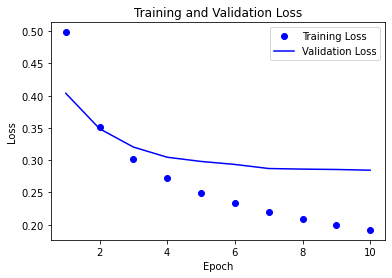

In [21]:
plot_loss_graph(base_history_dict['loss'], base_history_dict['val_loss'])

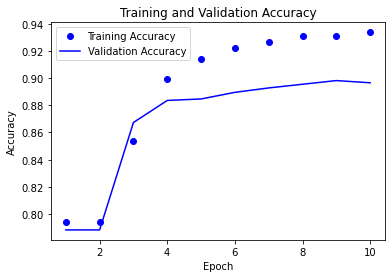

In [22]:
plot_accuracy_graph(base_history_dict['accuracy'], base_history_dict['val_accuracy'])

In [23]:
base_model.evaluate(X_test_matrix, y_test_categorise)

73/73 [==============================] - 0s 911us/step - loss: 0.2755 - accuracy: 0.9030


[0.2754655182361603, 0.9029883146286011]

With this it can be seen that the base model has an accuracy of 90%, and from that I can say that the current base model has achieved statistical power that is better than baseline.

### Overfitting Model

Now we create an overfitting model, and to do this I increased the number of layers, increase the layers size and the epoch value

#### Build

In [24]:
overfitting_model = models.Sequential([
    layers.Flatten(input_shape=(10000,)),
    layers.Dense(124, activation='relu'),
    layers.Dense(124, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(48, activation='relu'),
    layers.Dense(16, activation='relu'),  
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),  
    layers.Dense(2, activation='sigmoid')
])

overfitting_model.summary()

overfitting_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 124)               1240124   
                                                                 
 dense_3 (Dense)             (None, 124)               15500     
                                                                 
 dense_4 (Dense)             (None, 64)                8000      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 48)                3120      
                                                                 
 dense_7 (Dense)             (None, 16)               

#### Train

In [25]:
overfitting_history = overfitting_model.fit(
    X_train_second,
    y_train_second,
    epochs=15,
    validation_data=(X_validation, y_validation)
)

Epoch 1/15
231/231 [==============================] - 3s 9ms/step - loss: 0.5187 - accuracy: 0.8116 - val_loss: 0.3386 - val_accuracy: 0.8598
Epoch 2/15
231/231 [==============================] - 2s 9ms/step - loss: 0.2665 - accuracy: 0.9200 - val_loss: 0.2981 - val_accuracy: 0.8912
Epoch 3/15
231/231 [==============================] - 2s 9ms/step - loss: 0.1939 - accuracy: 0.9434 - val_loss: 0.2697 - val_accuracy: 0.9020
Epoch 4/15
231/231 [==============================] - 2s 9ms/step - loss: 0.1238 - accuracy: 0.9653 - val_loss: 0.2959 - val_accuracy: 0.9117
Epoch 5/15
231/231 [==============================] - 2s 9ms/step - loss: 0.0874 - accuracy: 0.9725 - val_loss: 0.2997 - val_accuracy: 0.8966
Epoch 6/15
231/231 [==============================] - 2s 9ms/step - loss: 0.0699 - accuracy: 0.9763 - val_loss: 0.3248 - val_accuracy: 0.9080
Epoch 7/15
231/231 [==============================] - 2s 9ms/step - loss: 0.0581 - accuracy: 0.9819 - val_loss: 0.4139 - val_accuracy: 0.9107
Epoch 

In [26]:
overfitting_history_dict = overfitting_history.history
overfitting_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

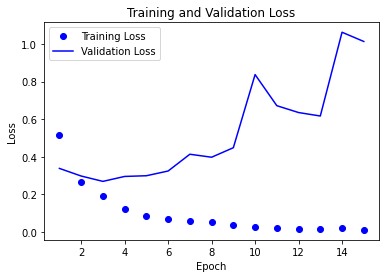

In [27]:
plot_loss_graph(overfitting_history_dict['loss'], overfitting_history_dict['val_loss'])

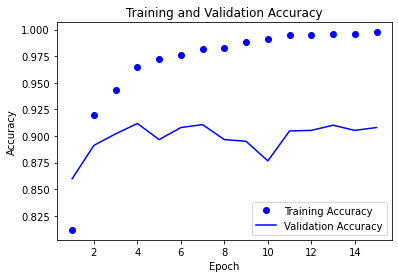

In [28]:
plot_accuracy_graph(overfitting_history_dict['accuracy'], overfitting_history_dict['val_accuracy'])

It can be seen that the model overfits by looking at the graph comparing Losses where the validation loss increases and validation accuracy decreases


### Developing a well performing model

Currently I have, 2 models where 1 is baseline and the other model overfit.
Now I will try to achieve a model that can have its best performance, in an attempt to achieve a model that is well performing, I have different options that can deal with overfitting and can help with obtaining an optimal configuration.

1) Apply regularization 

2) use Dropout layers

3) Reduce the network layers or reduce the number of elements within hidden layers

The purpose would be to achieve a high accuracy value and find a good fit in a model

I attempted reducing the number of layers and the epoch size

In [29]:
model_1 = models.Sequential([
    layers.Flatten(input_shape=(10000,)),
    layers.Dense(46, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model_1.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model1_history = model_1.fit(
    X_train_second,
    y_train_second,
    epochs=10,
    validation_data=(X_validation, y_validation)
)

Epoch 1/10
231/231 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.8349 - val_loss: 0.3123 - val_accuracy: 0.8890
Epoch 2/10
231/231 [==============================] - 1s 4ms/step - loss: 0.2593 - accuracy: 0.9177 - val_loss: 0.3093 - val_accuracy: 0.8917
Epoch 3/10
231/231 [==============================] - 1s 4ms/step - loss: 0.2265 - accuracy: 0.9318 - val_loss: 0.3122 - val_accuracy: 0.8901
Epoch 4/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1996 - accuracy: 0.9430 - val_loss: 0.3061 - val_accuracy: 0.8885
Epoch 5/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1755 - accuracy: 0.9515 - val_loss: 0.3029 - val_accuracy: 0.8863
Epoch 6/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1539 - accuracy: 0.9598 - val_loss: 0.3299 - val_accuracy: 0.8896
Epoch 7/10
231/231 [==============================] - 1s 4ms/step - loss: 0.1346 - accuracy: 0.9660 - val_loss: 0.3291 - val_accuracy: 0.8890
Epoch 

In [30]:
model1_history_dict = model1_history.history
model1_min_epoch = optimal_epoch(model1_history_dict)

Minimum validation loss reached in epoch 5


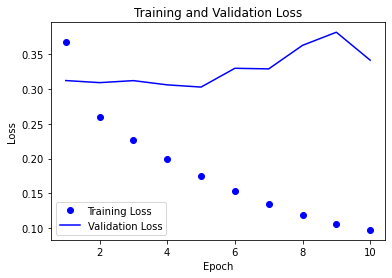

In [31]:
plot_loss_graph(model1_history_dict['loss'], model1_history_dict['val_loss'])

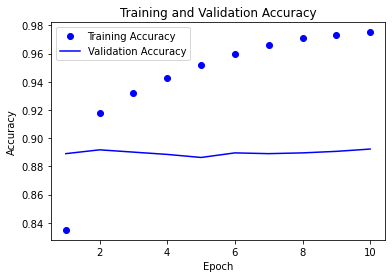

In [32]:
plot_accuracy_graph(model1_history_dict['accuracy'], model1_history_dict['val_accuracy'])

It can be seen that it is still overfitting , now i can try adding drop out layers and also reducing the epoch size from 10 to 8

In [33]:
model_2 = models.Sequential([
    layers.Flatten(input_shape=(10000,)),
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])

model_2.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2_history = model_2.fit(
    X_train_second,
    y_train_second,
    epochs=10,
    validation_data=(X_validation, y_validation)
)

Epoch 1/10
231/231 [==============================] - 1s 2ms/step - loss: 0.5424 - accuracy: 0.8008 - val_loss: 0.4295 - val_accuracy: 0.8121
Epoch 2/10
231/231 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8445 - val_loss: 0.3502 - val_accuracy: 0.8565
Epoch 3/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3588 - accuracy: 0.8729 - val_loss: 0.3104 - val_accuracy: 0.8733
Epoch 4/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3251 - accuracy: 0.8867 - val_loss: 0.2886 - val_accuracy: 0.8863
Epoch 5/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2968 - accuracy: 0.8932 - val_loss: 0.2746 - val_accuracy: 0.8960
Epoch 6/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2808 - accuracy: 0.8949 - val_loss: 0.2669 - val_accuracy: 0.8998
Epoch 7/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.9002 - val_loss: 0.2625 - val_accuracy: 0.9009
Epoch 

In [34]:
model2_history_dict = model2_history.history
model2_min_epoch = optimal_epoch(model2_history_dict)

Minimum validation loss reached in epoch 10


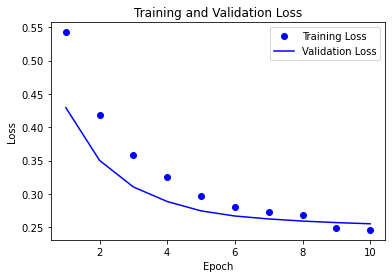

In [35]:
plot_loss_graph(model2_history_dict['loss'], model2_history_dict['val_loss'])

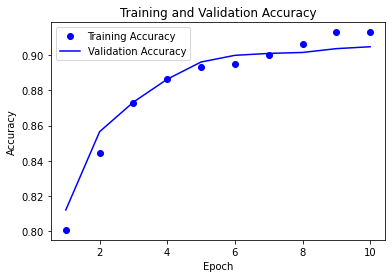

In [36]:
plot_accuracy_graph(model2_history_dict['accuracy'], model2_history_dict['val_accuracy'])

In [37]:
model_2.evaluate(X_test_matrix, y_test_categorise)

73/73 [==============================] - 0s 848us/step - loss: 0.2375 - accuracy: 0.9125


[0.23753297328948975, 0.9125162363052368]

Minimum epoch values is still 8.

It can be seen that there is an improvement comparing model1 and model2. 
As I attempt to try regularization in the next model(model3).

I added regularization, with L1 regularizers in one of the layers.

In [38]:
model_3 = models.Sequential([
    layers.Flatten(input_shape=(10000,)),
    layers.Dense(4, activity_regularizer=regularizers.L1(0.01), activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='sigmoid')
])

model_3.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model3_history = model_3.fit(
    X_train_second,
    y_train_second,
    epochs=10,
    validation_data=(X_validation, y_validation)
)

Epoch 1/10
231/231 [==============================] - 1s 2ms/step - loss: 0.5542 - accuracy: 0.7915 - val_loss: 0.4572 - val_accuracy: 0.7883
Epoch 2/10
231/231 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.8016 - val_loss: 0.3888 - val_accuracy: 0.8002
Epoch 3/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.8452 - val_loss: 0.3518 - val_accuracy: 0.8517
Epoch 4/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8761 - val_loss: 0.3272 - val_accuracy: 0.8749
Epoch 5/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3275 - accuracy: 0.8729 - val_loss: 0.3123 - val_accuracy: 0.8879
Epoch 6/10
231/231 [==============================] - 0s 2ms/step - loss: 0.3067 - accuracy: 0.8835 - val_loss: 0.3005 - val_accuracy: 0.8977
Epoch 7/10
231/231 [==============================] - 0s 2ms/step - loss: 0.2932 - accuracy: 0.8856 - val_loss: 0.2932 - val_accuracy: 0.8993
Epoch 

In [39]:
model3_history_dict = model3_history.history
model3_min_epoch = optimal_epoch(model3_history_dict)

Minimum validation loss reached in epoch 10


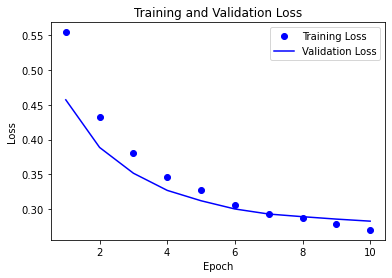

In [40]:
plot_loss_graph(model3_history_dict['loss'], model3_history_dict['val_loss'])

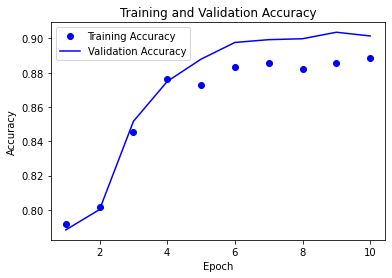

In [41]:
plot_accuracy_graph(model3_history_dict['accuracy'], model3_history_dict['val_accuracy'])

In [42]:
model_3.evaluate(X_test_matrix, y_test_categorise)

73/73 [==============================] - 0s 855us/step - loss: 0.2638 - accuracy: 0.9117


[0.26382210850715637, 0.9116500616073608]

## Results

In [43]:
model1_result = test_model_with_optimal_epoch(model_1, X_train_matrix, y_train_categorise, X_test_matrix, y_test_categorise, model1_min_epoch)

Epoch 1/5
289/289 [==============================] - 1s 4ms/step - loss: 0.1371 - accuracy: 0.9604
Epoch 2/5
289/289 [==============================] - 1s 4ms/step - loss: 0.1213 - accuracy: 0.9653
Epoch 3/5
289/289 [==============================] - 1s 4ms/step - loss: 0.1125 - accuracy: 0.9680
Epoch 4/5
289/289 [==============================] - 1s 4ms/step - loss: 0.1044 - accuracy: 0.9704
Epoch 5/5
73/73 [==============================] - 0s 883us/step - loss: 0.3233 - accuracy: 0.9039
Test accuracy: 90.39%


In [44]:
model2_result = test_model_with_optimal_epoch(model_2, X_train_matrix, y_train_categorise, X_test_matrix, y_test_categorise, model2_min_epoch)

Epoch 1/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2588 - accuracy: 0.9105
Epoch 2/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2508 - accuracy: 0.9126
Epoch 3/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2430 - accuracy: 0.9115
Epoch 4/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2389 - accuracy: 0.9183
Epoch 5/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.9191
Epoch 6/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2318 - accuracy: 0.9187
Epoch 7/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2248 - accuracy: 0.9236
Epoch 8/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2224 - accuracy: 0.9243
Epoch 9/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2189 - accuracy: 0.9233
Epoch 10/10
73/73 [==============================] - 0s 827us/step - loss: 0.2173 - accuracy: 0.9229

In [45]:
model3_result = test_model_with_optimal_epoch(model_3, X_train_matrix, y_train_categorise, X_test_matrix, y_test_categorise, model3_min_epoch)

Epoch 1/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2737 - accuracy: 0.8890
Epoch 2/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2721 - accuracy: 0.8902
Epoch 3/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2653 - accuracy: 0.8921
Epoch 4/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2585 - accuracy: 0.8955
Epoch 5/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2575 - accuracy: 0.8960
Epoch 6/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.9024
Epoch 7/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2497 - accuracy: 0.9011
Epoch 8/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2476 - accuracy: 0.9044
Epoch 9/10
289/289 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.9014
Epoch 10/10
73/73 [==============================] - 0s 841us/step - loss: 0.2518 - accuracy: 0.9168

As a result, It can be seen that I was able to achieve a model that is between 90 - 92% accuracy. As it can be seen in comparison for baseline model and model that I have drafted with better results 

### Baseline Model Graph

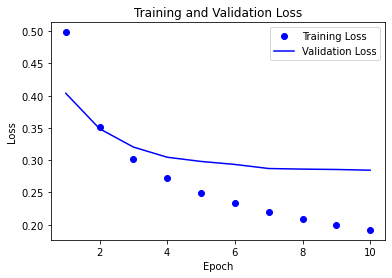

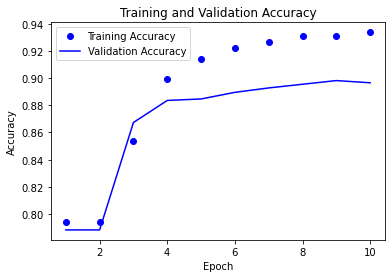

In [46]:
plot_loss_graph(base_history_dict['loss'], base_history_dict['val_loss'])
plot_accuracy_graph(base_history_dict['accuracy'], base_history_dict['val_accuracy'])

### Model 2

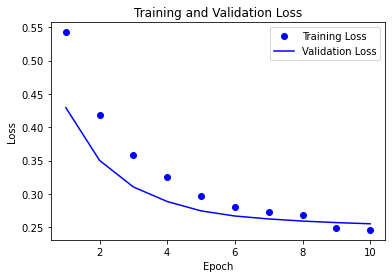

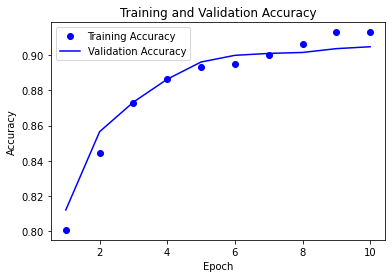

In [47]:
plot_loss_graph(model2_history_dict['loss'], model2_history_dict['val_loss'])
plot_accuracy_graph(model2_history_dict['accuracy'], model2_history_dict['val_accuracy'])

## Conclusion

I was able to train a model to achieve a slightly better accuracy than the baseline. Because I choose a dataset from kaggle, preparing the dataset for the models required a considerable amount of research since it is something I had to manually clean with filtering the stopwards and removing sections of the text like tags and prepare to be able to feed into the models.

While tuning the models in order to retrieve a good model, it took a long time due to how long it takes to train the data. With the different options to reduce overfitting, the model still does overfit easily no matter how minor the modification of layers were, which ultimately was very time consuming. It can be seen that the model with the dropout layers perform the best on the test data.

There there are more effective ways to increase accuracy that I have not explored one example would be to Ensemble models where we combine individual models [Ensemble Models](https://www.sciencedirect.com/topics/computer-science/ensemble-modeling#:~:text=Ensemble%20modeling%20is%20a%20process,prediction%20for%20the%20unseen%20data.)

## References

- dataframe, P. and Foley, L., 2022. Python remove stop words from pandas dataframe. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe>

- Adamsmith.haus. 2022. Kite. Remove Tags [online] Available at: <https://www.adamsmith.haus/python/answers/how-to-use-re.sub()-in-python#:~:text=sub()%20to%20replace%20patterns,pattern%20in%20string%20with%20repl%20.>

- TensorFlow. 2022. tf.keras.preprocessing.text.Tokenizer  |  TensorFlow Core v2.8.0. [online] Available at: <https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer>

- TensorFlow. 2022. tf.keras.utils.to_categorical  |  TensorFlow Core v2.8.0. [online] Available at: <https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical>

- Ensemble Modeling. 2015. Data Mining Process. [online] Available at: <https://www.sciencedirect.com/topics/computer-science/ensemble-modeling#:~:text=Ensemble%20modeling%20is%20a%20process,prediction%20for%20the%20unseen%20data.>

- Kaggle.com. 2022. Twitter US Airline Sentiment. Dataset Used [online] Available at: <https://www.kaggle.com/crowdflower/twitter-airline-sentiment>